In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

For a first example, we will use a small dataset of 8x8 pixel images of handwritten digits.

X.shape = (1797, 8, 8)
y.shape = (1797,)


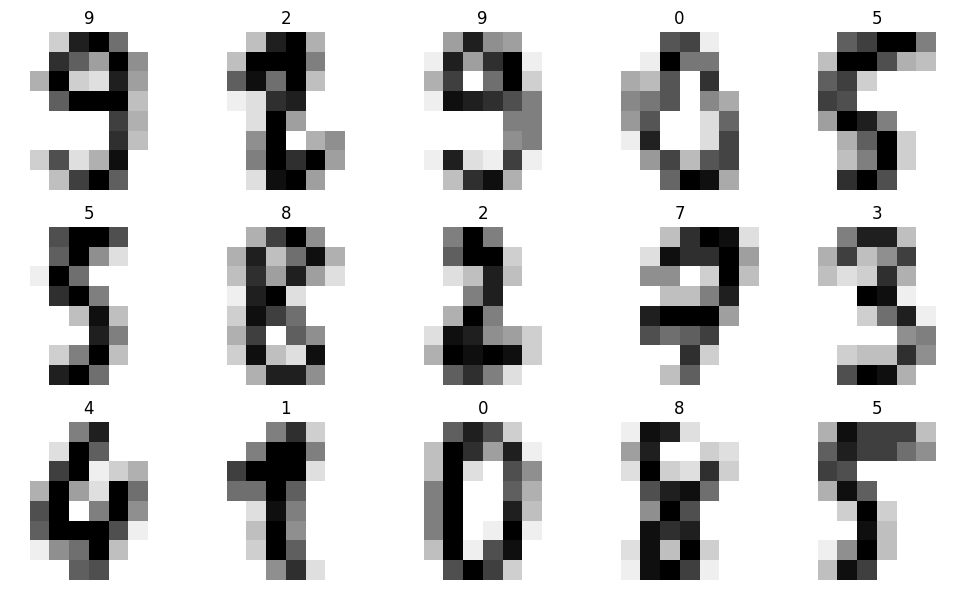

In [11]:
data = load_digits()
X = data.images
y = data.target
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols,2*n_rows), dpi=100)
for row in range(n_rows):
    for col in range(n_cols):
        ind = np.random.randint(len(data.images))
        axes[row][col].imshow(data.images[ind, ...], cmap='binary')
        axes[row][col].axis("off")
        axes[row][col].set_title(str(data.target[ind]))
fig.tight_layout()

To prepare the dataset, we flatten each 8x8 image into a 64-element vector.
To avoid overfitting on the training set, we split the dataset in 2:
 - A training set, on which we will train our model
 - A test set, which we will use to test accuracy of our model on unseen data

In [12]:
X = X.reshape([-1, 64])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1400)

All models in sckit-learn share a common interface:

- A **fit()** function to train the model
- A **predict()** function to evaluate the model on (new) data

This makes it easy to quickly test different methods on the same dataset.


As a first model we will try a Naive Bayesian Classifier:
It uses Bayes' Theorem and makes the following assumptions:
 - The input features are independent of each other
 - The individual likelihoods are Gaussian

$$p(y|\boldsymbol{x}) = \frac{p(y) p(\boldsymbol{x} | y)}{p(\boldsymbol{x})} \qquad $$

$$p(\boldsymbol{x} | y) \stackrel{\text{indep.}}{=} \prod_i p(x_i | y) \stackrel{\text{Gauss.}}{=} \prod_i e^{-\frac{1}{2} \left(\frac{x_i-\mu_{y,i}}{\sigma_{y,i}} \right)^2 }$$

$$p(y|\boldsymbol{x}) \propto p_y\, e^{-\frac{1}{2}\sum_i \left(\frac{x_i-\mu_{y,i}}{\sigma_{y,i}} \right)^2 }$$

Effectively this means for each class we get 2 matrices:

- $\mu_i$ containing the average pixel value of all training samples in that class
- $\sigma_i$ containing the standard devaiation of pixel values within that class


In [13]:
print("Naive Bayes classifier on raw data:")
model = GaussianNB()
model.fit(X_train, y_train)

def evaluate_model(trained_model):
    y_pred_train = trained_model.predict(X_train)
    y_pred_test = trained_model.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    print(f"Training accuracy: {acc_train:.0%}")
    print(f"Test accuracy    : {acc_test:.0%}")
    return y_pred_train, y_pred_test

_,_ = evaluate_model(model)

Naive Bayes classifier on raw data:
Training accuracy: 87%
Test accuracy    : 86%


Assuming that the individual pixel values are independent is apprently too naive.
Let's instead calculate the PCA first and then apply naive Bayes on these transformed features.

Since all sklearn models share the same interface, it is easy to chain them together into Pipelines, applying one data processing step after the other:

In [14]:

print("PCA + Naive Bayes classifier:")
model = Pipeline([('pca', PCA(n_components=10)),
                  ('naive_bayes', GaussianNB())
                  ])
model.fit(X_train, y_train)
_,_ = evaluate_model(model)

PCA + Naive Bayes classifier:
Training accuracy: 92%
Test accuracy    : 91%


Lastly we can try a full linear model (logistic regression):

$$ p(y | \boldsymbol{x}) = \frac{ \exp(\boldsymbol{w_y}^T \boldsymbol{x})}{\sum_{y'}\exp(\boldsymbol{w_{y'}}^T \boldsymbol{x})}$$


Linear classifier on raw input data:
Training accuracy: 98%
Test accuracy    : 98%


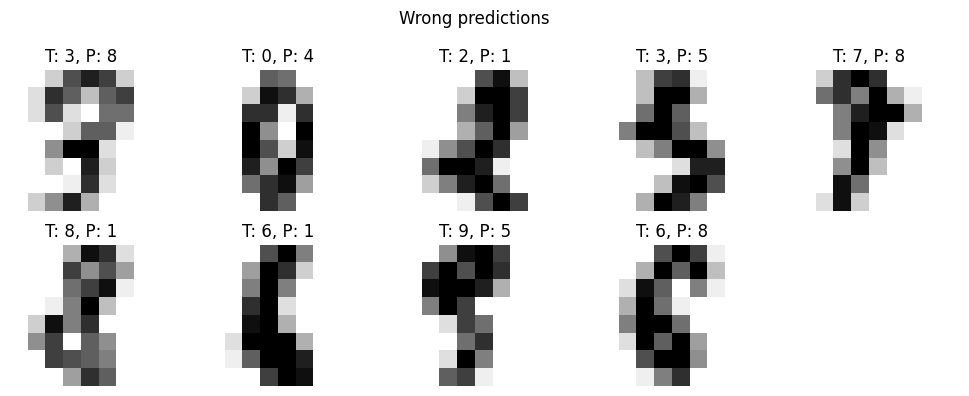

In [15]:
print("Linear classifier on raw input data:")
model = LogisticRegression(C=0.005, max_iter=1000)
model.fit(X_train, y_train)
_, y_pred_test = evaluate_model(model)
ind_wrong = (y_pred_test != y_test)

n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols,2*n_rows), dpi=100)
for i, (img, y_true, y_pred) in enumerate(zip(X_test[ind_wrong],
                                              y_test[ind_wrong],
                                              y_pred_test[ind_wrong])):
    if i >= (n_rows * n_cols):
        break
    ax = axes[i//n_cols][i%n_cols]
    ax.imshow(img.reshape([8,8]), cmap='binary')
    ax.set_title(f"T: {y_true}, P: {y_pred}")
for ax in axes.flatten():
    ax.axis("off")
fig.suptitle("Wrong predictions")
fig.tight_layout()

